In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
def bootsrtap_samples(data, n):
    inds = np.random.choice(np.arange(len(data)), size=(n, len(data)))
    return data[inds]

In [3]:
df = pd.read_csv('Cats.txt', ';', index_col='N')

### Ex. 1

Построить 95% бутстрэп интервал для средней разности веса сердца(Hwt) самца и самки

In [4]:
m_hwt = df[df.Sex == 'M'].Hwt.values.reshape(1, -1)
f_hwt = df[df.Sex == 'F'].Hwt.values.reshape(1, -1)
sample_diff = (m_hwt.T - f_hwt).reshape(-1)
theta = sample_diff.mean()
theta

2.1205527527966663

In [5]:
b_theta = bootsrtap_samples(sample_diff, 3000).mean(axis=1)

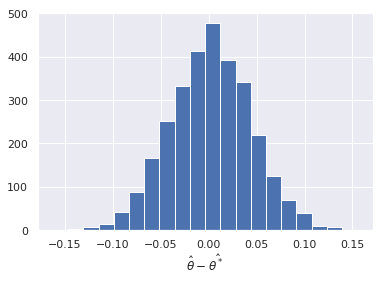

In [6]:
_ = plt.hist(b_theta - theta, bins=20)
_ = plt.xlabel(r'$\hat{\theta} - \hat{\theta^*}$')

Как видно по графику разброс оказалася симметричным около нуля, следовательно мы можем применить Percentile метод

In [7]:
alpha = 0.01
gamma = 0.005
beta = 1 - alpha + gamma
t1, t2 = b_theta[round(gamma * len(b_theta))], b_theta[round(beta * len(b_theta))]
print(f'Confidence interval: ({t1:.4f}, {t2:.4f})')

Confidence interval: (2.0654, 2.0994)


### Ex. 2

Построить оценку плотности для веса сердца кошек каждого пола, графически подобрать оптимальный шаг и сравнить с плотностями построенными в distplot по умолчанию. Как влияет на график плотности смена гауссовского ядра на прямоугольное.

In [8]:
def gauss_kde(data, h):
    ker = lambda x: 1/(2*np.pi)**0.5 * np.exp(-x**2 / 2)
    return np.array(
        list(
            map(lambda x: 1/len(data) * np.sum(1/h * ker((x - data) / h)), data)
        )
    )

def rect_kde(data, h):
    ker = lambda x: 1/2 * ((-1 <= x) & (x <= 1))
    return np.array(
        list(
            map(lambda x: 1/len(data) * np.sum(1/h * ker((x - data) / h)), data)
        )
    )

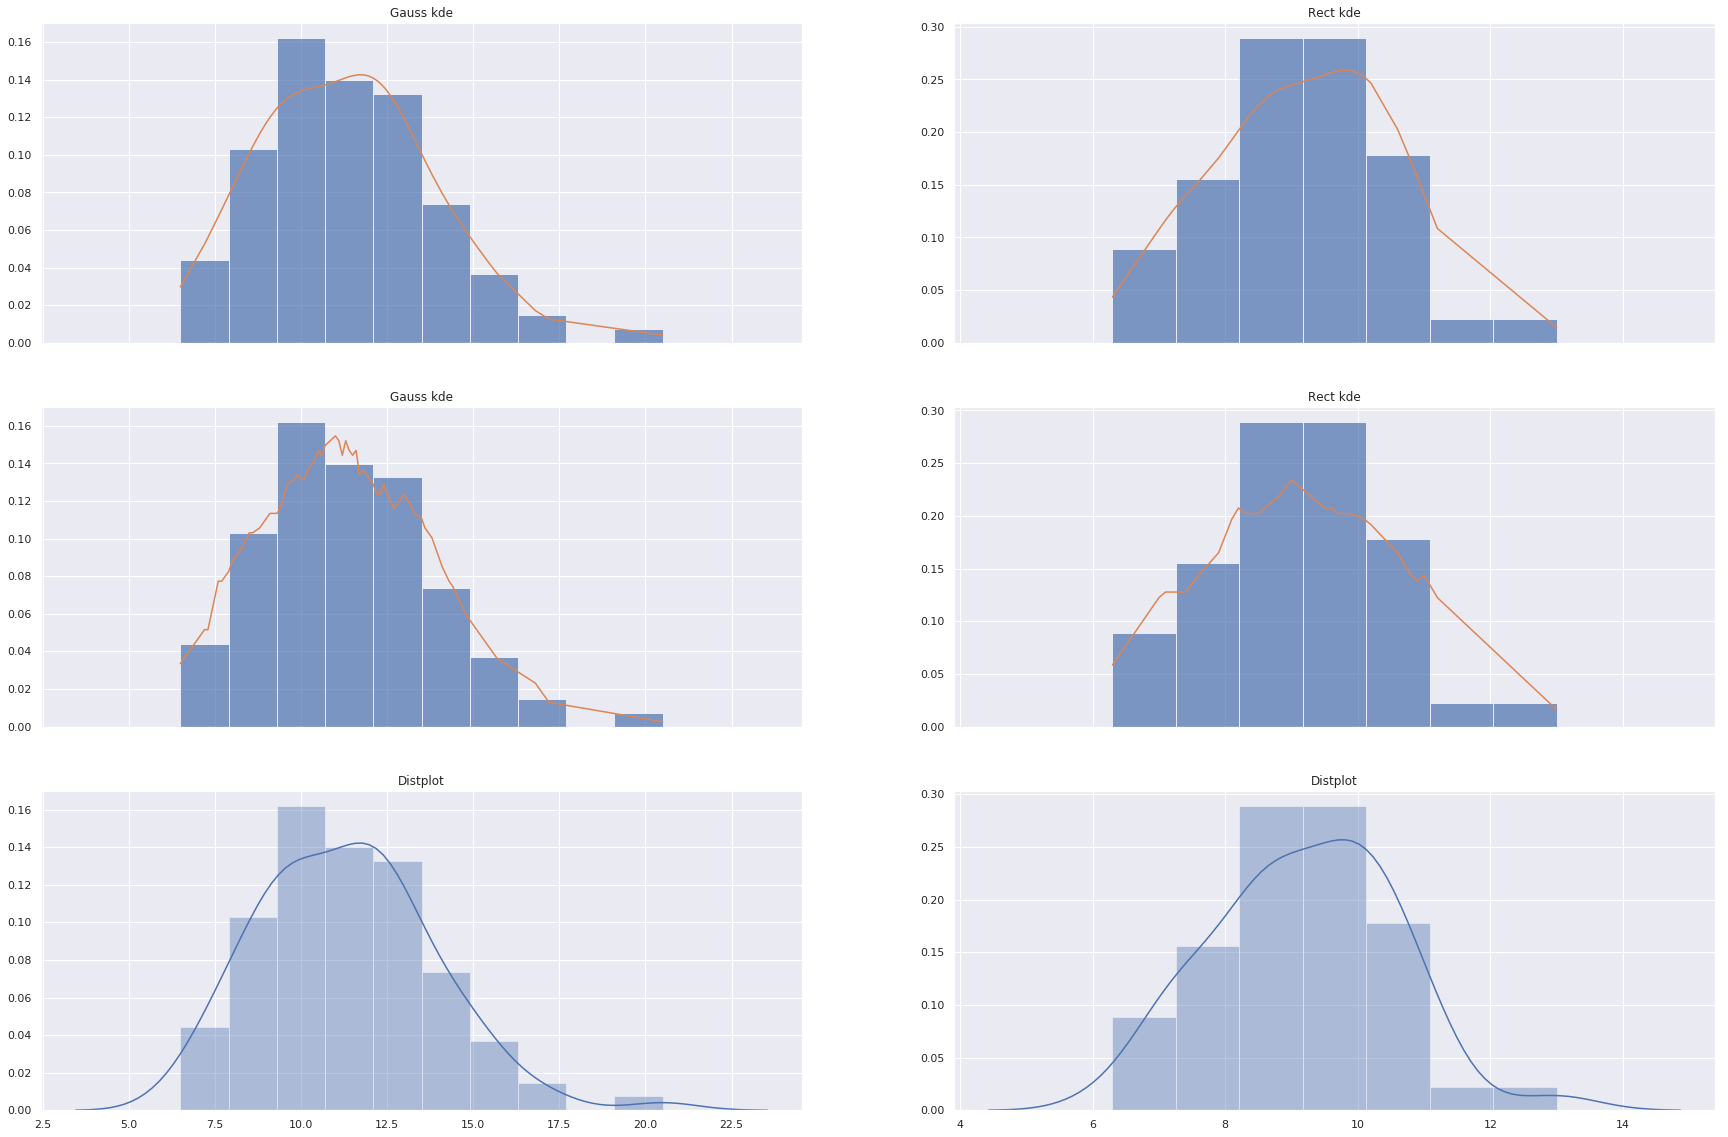

In [9]:
m_hwt = np.sort(df[df.Sex == 'M'].Hwt.values)
f_hwt = np.sort(df[df.Sex == 'F'].Hwt.values)
ker = [gauss_kde, rect_kde]
hm = [1, 2]
hf = [0.6, 2]

_, axes = plt.subplots(3, 2, figsize=(30, 20), sharex='col')
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        if i < 2:
            if not j % 2:
                col.hist(m_hwt, alpha=0.7, density=True)
                col.plot(m_hwt, ker[i](m_hwt, h=hm[i]))
                col.set_title('Gauss kde')
            else:
                col.hist(f_hwt, alpha=0.7, density=True, bins=7)
                col.plot(f_hwt, ker[i](f_hwt, h=hf[i]))
                col.set_title('Rect kde')
        else:
            col.set_title('Distplot')
            if not j % 2:
                sns.distplot(m_hwt, ax=col)
            else:
                sns.distplot(f_hwt, ax=col)

При смене гауссовсского ядра на прямоугольное ядро теряется гладкость оценки функции плотности 

### Ex. 3

Построить доверительную полосу для функции  $F$ распределения веса кошек

Для этого воспользуемся неравенством Дворецкого-Кифера-Вольфовица:

$P\left(\left|F_n - F\right| > \varepsilon\right) \leq 2e^{-2n\varepsilon^2}$

Откуда получаем:

$\alpha = 2e^{-2n\varepsilon^2}$

$\varepsilon = \sqrt{\frac{\ln \frac{2}{\alpha}}{2n}}$

In [10]:
def ecdf(x, data):
    return np.sum(data <= x) / len(data)

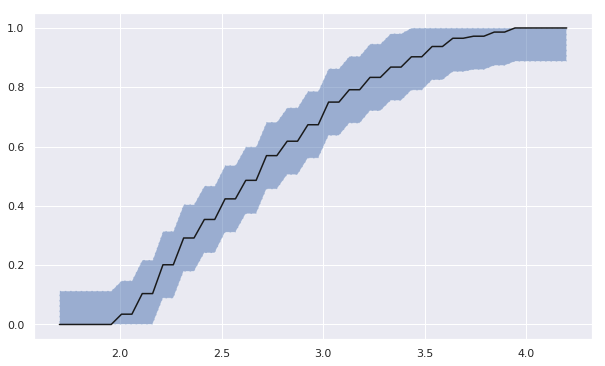

In [13]:
bwt = np.sort(df.Bwt)
x = np.linspace(min(bwt) - 0.3, max(bwt) + 0.3)

alpha = 0.05
eps = np.sqrt(np.log(2/alpha) / 2 / len(bwt))
f_n = np.array(list(map(lambda y: ecdf(y, bwt), x)))
plt.figure(figsize=(10, 6))
_ = plt.plot(x, f_n, 'k')
_ = plt.fill_between(x, np.maximum(f_n - eps, 0), np.minimum(f_n + eps, 1), linestyle='dashed', alpha=0.5)